# Example: Custom `MoveStrategy`: RepEx-Shoot-Repex

One of the powerful features in OpenPathSampling is that it is very easy to develop new Monte Carlo movers for path space. This example shows how easy it is to try out a new type of move. The particular move we use here can be easily described as a simple combination of existing moves, so we don't even need to define a new `PathMover` subclass. We just define a custom `MoveStrategy` that creates the desired `PathMover`, and use that directly.

The idea implemented here is pretty simple. Our standard path movers treat shooting and replica exchange separately, and each move is a single shooting (one ensemble) or a single replica exchange (swap one pair). But maybe you could get better replica exchange behavior by trying all the replica exchange moves, and then trying all the shooting moves. Note that, to satisfy detailed balance, you really have to do all the replica exchange moves, then all the shooting moves, then all the replica exchange moves in the reverse order from before. To measure how this affects travel in replica space, we'll use the replica round trip time (normalized to the total number of shooting moves per ensemble).

In [1]:
import openpathsampling as paths
import numpy as np

# Set up the simulation

## Set up the engine

In [2]:
import openpathsampling.engines.toy as toys
pes = (toys.OuterWalls([1.0,1.0], [0.0,0.0]) + 
       toys.Gaussian(-0.7, [12.0, 0.5], [-0.5, 0.0]) +
       toys.Gaussian(-0.7, [12.0, 0.5], [0.5, 0.0]))

topology = toys.Topology(n_spatial=2, masses=[1.0, 1.0], pes=pes)

engine = toys.Engine(options={'integ': toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5),
                              'n_frames_max': 5000,
                              'n_steps_per_frame': 10},
                     topology=topology)

template = toys.Snapshot(coordinates=np.array([[0.0, 0.0]]),
                         velocities=np.array([[0.0, 0.0]]),
                         engine=engine)

## Set up CV and volumes (states, interfaces)

In [3]:
# states are volumes in a CV space: define the CV
def xval(snapshot):
    return snapshot.xyz[0][0]

cv = paths.FunctionCV("xval", xval)

stateA = paths.CVDefinedVolume(cv, float("-inf"), -0.5).named("A")
stateB = paths.CVDefinedVolume(cv, 0.5, float("inf")).named("B")
interfaces_AB = paths.VolumeInterfaceSet(cv, float("-inf"), [-0.5, -0.4, -0.3])#, -0.2, -0.1, 0.0])

## Set up network

In [4]:
network = paths.MISTISNetwork([(stateA, interfaces_AB, stateB)])

## Define a custom strategy

This is the main point of this example: Here we create a custom `MoveStrategy`, which includes the creation of the custom mover. Note that the custom mover itself is quite simple. It takes a bunch of moves that have already been defined, and combines them into a different move.

This is a `GROUP`-level mover, meaning that it only acts after you've already movers in the `SIGNATURE` level. Because of this, all it has to do is to reorganize the movers that already exist.

In [5]:
import openpathsampling.analysis.move_strategy as strategies # TODO: handle this better
# example: custom subclass of `MoveStrategy`
class RepExShootRepExStrategy(strategies.MoveStrategy):
    _level = strategies.levels.GROUP
    # we define an init function mainly to set defaults for `replace` and `group`
    def __init__(self, ensembles=None, group="repex_shoot_repex", replace=True, network=None):
        super(RepExShootRepExStrategy, self).__init__(
            ensembles=ensembles, group=group, replace=replace
        )
            
    def make_movers(self, scheme):
        # if we replace, we remove these groups from the scheme.movers dictionary
        if self.replace:
            repex_movers = scheme.movers.pop('repex')
            shoot_movers = scheme.movers.pop('shooting')
        else:
            repex_movers = scheme.movers['repex']
            shoot_movers = scheme.movers['shooting']
        # combine into a list for the SequentialMover
        mover_list = repex_movers + shoot_movers + list(reversed(repex_movers))
        combo_mover = paths.SequentialMover(mover_list)
        return [combo_mover]

## Create two move schemes: Default and Custom

In [6]:
default_scheme = paths.DefaultScheme(network, engine)

In [7]:
custom_scheme = paths.DefaultScheme(network, engine)
custom_scheme.append(RepExShootRepExStrategy())

# Get initial conditions

In [8]:
initial_samples = paths.FullBootstrapping(transition=network.sampling_transitions[0],
                                          snapshot=template,
                                          engine=engine).run()

DONE! Completed Bootstrapping cycle step 132 in ensemble 3/3.


In [9]:
transition = network.sampling_transitions[0]
minus_sample = network.minus_ensembles[0].populate_minus_ensemble(
    partial_traj=initial_samples[transition.ensembles[0]].trajectory,
    minus_replica_id=-1,
    engine=engine
)
initial_samples = initial_samples.apply_samples(minus_sample)

In [10]:
initial_samples.sanity_check()

In [11]:
print "Default Scheme:", default_scheme.initial_conditions_report(initial_samples)
print "Custom Scheme:", custom_scheme.initial_conditions_report(initial_samples)

Default Scheme: No missing ensembles.
No extra ensembles.

Custom Scheme: No missing ensembles.
No extra ensembles.



# Run each of the simulations

In [12]:
n_tries_per_shooting = 1000

In [13]:
# take the number of steps from a single ensemble shooting
n_steps = default_scheme.n_steps_for_trials(
    mover=default_scheme.movers['shooting'][0],
    n_attempts=n_tries_per_shooting
)
n_steps = int(n_steps)+1
print n_steps

5701


In [14]:
default_storage = paths.Storage("default_scheme.nc", "w")

In [15]:
default_calc = paths.PathSampling(
    storage=default_storage,
    sample_set=initial_samples,
    move_scheme=default_scheme
)
default_calc.save_frequency = 100

In [16]:
default_calc.run(n_steps)

Working on Monte Carlo cycle number 5701.
DONE! Completed 5701 Monte Carlo cycles.


In [17]:
# in repex_shoot_repex, one move shoots all the ensembles
n_steps = custom_scheme.n_steps_for_trials(
    mover=custom_scheme.movers['repex_shoot_repex'],
    n_attempts=n_tries_per_shooting
)
n_steps = int(n_steps)+1
print n_steps

2701


In [18]:
custom_storage = paths.Storage("custom_scheme.nc", "w")

In [19]:
custom_calc = paths.PathSampling(
    storage=custom_storage,
    sample_set=initial_samples,
    move_scheme=custom_scheme
)
custom_calc.save_frequency = 100

In [20]:
custom_calc.run(n_steps)

Working on Monte Carlo cycle number 2701.
DONE! Completed 2701 Monte Carlo cycles.


# Analyze the results

## A few checks that we are making a fair comparison

### The scheme should be as expected

In [21]:
default_scheme.move_summary(default_storage.steps)

repex ran 17.962% (expected 17.54%) of the cycles with acceptance 348/1024 (33.98%)
shooting ran 52.394% (expected 52.63%) of the cycles with acceptance 2275/2987 (76.16%)
minus ran 3.420% (expected 3.51%) of the cycles with acceptance 194/195 (99.49%)
pathreversal ran 26.223% (expected 26.32%) of the cycles with acceptance 1472/1495 (98.46%)


In [22]:
custom_scheme.move_summary(custom_storage.steps)

repex_shoot_repex ran 36.431% (expected 37.04%) of the cycles with acceptance 970/984 (98.58%)
minus ran 7.183% (expected 7.41%) of the cycles with acceptance 193/194 (99.48%)
pathreversal ran 56.387% (expected 55.56%) of the cycles with acceptance 1518/1523 (99.67%)


### The number of snapshots generated by each should be similar

In [23]:
print len(default_storage.snapshots), len(custom_storage.snapshots)

247898 236018


### Check that we have about the same number of shooting moves per ensemble for each scheme

In [24]:
default_scheme.move_summary(default_storage.steps, "shooting")

OneWayShootingMover [TISTransition] 0 ran 17.032% (expected 17.54%) of the cycles with acceptance 765/971 (78.78%)
OneWayShootingMover [TISTransition] 1 ran 18.242% (expected 17.54%) of the cycles with acceptance 833/1040 (80.10%)
OneWayShootingMover [TISTransition] 2 ran 17.120% (expected 17.54%) of the cycles with acceptance 677/976 (69.36%)


In [25]:
custom_scheme.move_summary(custom_storage.steps, "repex_shoot_repex")

Sequential ran 36.431% (expected 37.04%) of the cycles with acceptance 970/984 (98.58%)


## Analyze the output to compare the efficiency

### Count the number of round trips done

In [26]:
default_repx_net = paths.ReplicaNetwork(default_scheme, default_storage.steps)

In [27]:
default_trips = default_repx_net.trips(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

In [28]:
n_default_round_trips = len(default_trips['round'])
print n_default_round_trips

20


In [29]:
print default_trips

{'down': [24, 14, 296, 84, 222, 331, 293, 158, 907, 1571, 212, 724, 178, 76, 425, 296, 160, 87, 1969, 31], 'up': [425, 28, 237, 100, 1599, 503, 933, 367, 23, 737, 492, 501, 328, 3887, 180, 217, 555, 610, 740, 798], 'round': [449, 42, 533, 184, 1821, 834, 1226, 525, 930, 2308, 704, 1225, 506, 3963, 605, 513, 715, 697, 2709, 829]}


In [30]:
custom_repx_net = paths.ReplicaNetwork(custom_scheme, custom_storage.steps)

In [31]:
custom_trips = custom_repx_net.trips(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

In [32]:
n_custom_round_trips = len(custom_trips['round'])
print n_custom_round_trips

26


In [33]:
print custom_trips

{'down': [221, 173, 9, 223, 131, 41, 88, 20, 6, 12, 16, 346, 18, 84, 104, 72, 546, 204, 59, 94, 189, 13, 334, 48, 65, 722, 102], 'up': [365, 118, 669, 233, 454, 3, 643, 17, 559, 534, 285, 33, 101, 60, 258, 167, 719, 260, 26, 14, 39, 55, 441, 66, 24, 225, 189], 'round': [586, 291, 678, 456, 585, 44, 731, 37, 565, 546, 301, 379, 119, 144, 362, 239, 1265, 464, 120, 203, 52, 389, 489, 131, 746, 327]}


### Check the replica flow for each scheme

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

In [35]:
default_flow = default_repx_net.flow_pd(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

In [36]:
custom_flow = custom_repx_net.flow_pd(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

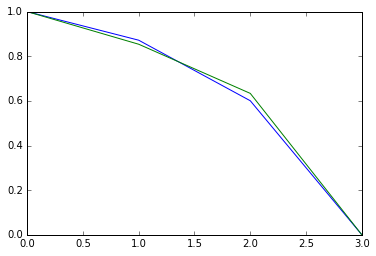

In [37]:
plt.plot(default_flow)
plt.plot(custom_flow)
plt.plot(range(len(default_flow)), range(len(default_flow)))